# Project 3 - Water Pump Clasificaiton

## Executive Summary

Text

# Notes

**Things to add to my project - ideas from class**

* SQL
* dummy set
    * DONE
* linear/rbf SVM
    * DONE on 15% of training data
* tableau
* decision tree
    * random forest
    * bagging
    


**To Do**
* MVP presentation


# Setup

In [64]:
from __future__ import print_function

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
pd.set_option('display.width',5000)

In [66]:
import patsy

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Data Import - Training Data

This data is part of the Data Driven Competition

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


In [67]:
# 'Values' provided for each pump location - features

df_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set values.csv')
df_values.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
56967,13791,500.0,2013-01-18,Tcrs,1275,TCRS,30.482801,-5.611496,Sokoni,0,...,monthly,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
32675,5407,20.0,2011-03-17,Unice,504,RWE,37.788899,-6.795863,Kwa Fuko,0,...,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
7051,36116,0.0,2011-07-22,Tasaf,0,DWE,33.759416,-9.529991,Kwa Akili Mwangona,0,...,never pay,soft,good,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump
50716,55264,0.0,2013-01-04,Government Of Tanzania,1507,DWE,36.662378,-3.340007,Kwa Christopher,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
48956,7031,300.0,2011-03-18,Dhv,255,RWE,36.704127,-8.122024,Kwandogoti,0,...,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [68]:
# 'Labels' provided for each pump location - clasificaiton - what I am predicting

df_labels = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set labels.csv')
df_labels.sample(5)

,id,status_group
33036,11890,non functional
6151,59830,functional
12193,62958,functional
28614,54762,functional
22381,66866,non functional


# Exploratory Data Analysis

## Colum descriptions

My goal is to predict the operating condition of a waterpoint for each record in the dataset. I was provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
    * 98 unique
* date_recorded - The date the row was entered
    * 365 unique
    * year - month - day
* funder - Who funded the well
    * 1897 unique
    * look at top ones?
* installer - Organization that installed the well
    * 2145 unique
    * DWE is main one - 10x closest other, 17k
* wpt_name - Name of the waterpoint if there is one
    * 37400 unique
    * look at top ones?
* num_private - (NO PROVIDED DESC)
    * 65 unique
    * USELESS FEATURE
* population - Population around the well
    * 1049 unique
    * a lot are zero
* public_meeting - True/False
    * 2 unique
* recorded_by - Group entering this row of data
    * 1 unique
    * all the same - USELESS FEATURE
* scheme_management - Who operates the waterpoint
    * 12 unique
* scheme_name - Who operates the waterpoint
    * 2696 unique
    * USELESS FEATURE
* permit - If the waterpoint is permitted
    * 2 unique
* construction_year - Year the waterpoint was constructed
    * 55 unique
    * third are 0 - USELESS FEATURE


* Geography
    * gps_height - Altitude of the well
        * numerical
    * longitude - GPS coordinate
        * numerical
    * latitude - GPS coordinate
        * numerical
    * basin - Geographic water basin
        * 9 unique
    * subvillage - Geographic location
        * 19287 unique
    * region - Geographic location
        * 21 unique
    * region_code - Geographic location (coded)
        * 27 unique
    * district_code - Geographic location (coded)
        * 20 unique
    * lga - Geographic location
        * 125 unique
    * ward - Geographic location
        * 2092 unique


* Extraction
    * extraction_type - The kind of extraction the waterpoint uses
        * 18 unique
        * Most descriptive of extraction
    * extraction_type_group - The kind of extraction the waterpoint uses
        * 13 unique
        * Parent of extraction_type
    * extraction_type_class - The kind of extraction the waterpoint uses
        * 7 unique
        * Parent of extraction_type_group


* Overhead
    * management - How the waterpoint is managed
        * 12 unique
    * management_group - How the waterpoint is managed
        * 5 unique
    * payment - What the water costs
        * 7 unique
        * same as payment type
    * payment_type - What the water costs
        * 7 unique
        * same as payment


* Water
    * water_quality - The quality of the water 
        * 3 unique
        * Subset of quality_group
    * quality_group - The quality of the water
        * 6 unique
        * Parent group of water_quality
    * quantity - The quantity of water
        * 5 unique
        * Same as quantity_group
    * quantity_group - The quantity of water
        * 5 unique
        * Same as quantity
    * source - The source of the water
        * 10 unique
    * source_type - The source of the water
        * 7 unique
        * Subset of source
    * source_class - The source of the water
        * 3 unique
        * Subset of source_type
    * waterpoint_type - The kind of waterpoint
        * 6 unique
        * Parent of waterpoint_type_group
    * waterpoint_type_group - The kind of waterpoint
        * 7 unique
        * Subset of waterpoint_type

## Various EDA

##### Status

In [69]:
# 3 Unique status present
df_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

##### Finding features

##### Review histograms of extraction data

* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses

18

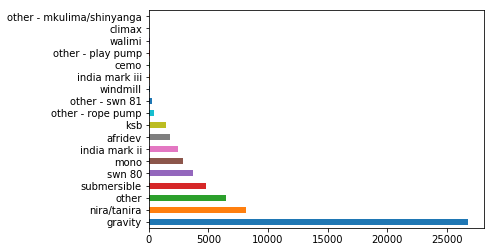

In [70]:
df_values.extraction_type.value_counts().plot('barh')
len(df_values.extraction_type.value_counts())

13

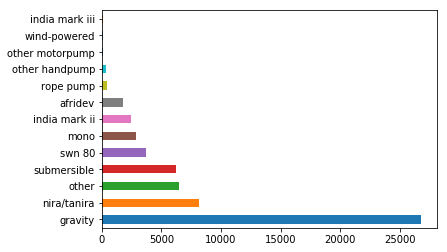

In [71]:
df_values.extraction_type_group.value_counts().plot('barh')
len(df_values.extraction_type_group.value_counts())

7

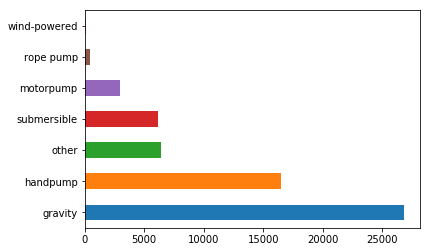

In [72]:
df_values.extraction_type_class.value_counts().plot('barh')
len(df_values.extraction_type_class.value_counts())

##### Other

In [73]:
# df_values.population.value_counts()

In [74]:
len(df_values.ward.value_counts())

2092

In [75]:
# len(df_values.management.value_counts())

In [76]:
# print(df_values.region.value_counts())
# print('Length: ',len(df_values.region.value_counts()))

In [77]:
#print(df_values.region_code.value_counts())
#print('Length: ',len(df_values.region_code.value_counts()))

In [78]:
# df_values.water_quality.value_counts()

In [79]:
#df_values.installer.value_counts()

# Test Train Split

In [80]:
# randomize data
# df_lables, df_values - combine and shuffle this data

df = pd.merge(df_labels,df_values,how = 'left')
df = df.sample(frac=1).reset_index(drop=True)

In [81]:
# Split back to X and y and then TTS
y = df[["id","status_group"]]
X = df.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Data Import - Challenge Data

In [134]:
# 'Values' provided for each competition pump location - features

df_test_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Test set values.csv')
df_test_values.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
1008,44827,0.0,2011-03-23,Danida,-11,DA,38.920764,-6.496556,Kwa Jambo,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
8163,496,3000.0,2011-03-11,Kkkt,2005,Commu,34.340357,-9.554417,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1375,9381,7.0,2013-03-18,Germany Republi,1566,CES,37.227967,-3.189975,Kwa James,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
9814,21877,0.0,2013-01-23,Tcrs,1089,TCRS,35.014392,-5.765881,Kwa Meshaki Mazuguni,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
3386,27596,0.0,2011-03-17,Kibaha Town Council,95,DWE,38.977181,-6.809135,Mwanalugali Secondary School 2,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


In [135]:
# 'Labels' I will provide for each pump location - clasificaiton

df_sub = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/SubmissionFormat.csv')
df_sub.sample(5)

,id,status_group
7884,2798,predicted label
11248,40722,predicted label
14597,15216,predicted label
2810,29617,predicted label
8435,37196,predicted label


In [136]:
df_sub = df_sub.drop('status_group', axis = 1)
df_sub.sample(5)

,id
12643,21502
9351,36311
9430,13798
10652,19079
13452,20630


# Dummy Classification

Functional is the highest output

In [85]:
# set everything to functional - most common - and submit for a baseline

df_sub['status_group'] = pd.Series('functional', index=df_sub.index)
df_sub.to_csv('./Submissions/dummy_classification.csv',index=False)

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.5461</td>
    <td>1342</td>
    <td>5030</td>
    <td>May 3, 2018, 8:37 p.m.</td>
  </tr>
</table>

# (Classification 2)

In [86]:
df.sample(5)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
49013,60935,functional,0.0,2011-04-09,NaN,0,NaN,33.837681,-9.297541,Suba,...,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1428,65558,non functional,0.0,2013-01-22,Finn Water,272,FINN WATER,38.095585,-9.340621,Kwa Mzee Matangula,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
2920,27319,non functional,50.0,2013-01-28,Mission,1124,Mission,35.020931,-6.426113,Kwa Mzee Asa,...,per bucket,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
32292,32932,functional,30.0,2011-02-18,Amref,61,AMREF,39.178009,-7.073220,Shuleni,...,per bucket,salty,salty,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump
35353,70141,functional needs repair,250.0,2013-02-09,Oxfam,1176,OXFAM,29.918675,-4.561380,Ruhiche Primary,...,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe


In [87]:
# try with a few less features first 

feature_no_sel = df[['amount_tsh', 'date_recorded', 'funder', 'installer', 
                   'wpt_name', 'num_private', 'subvillage', 'region', 
                   'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 
                   'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 
                   'extraction_type_group', 'management', 'management_group', 'payment', 
                   'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 
                   'source_type', 'waterpoint_type','region_code', 
                  'district_code']]

feature_sel = df[['id', 'status_group', 'gps_height', 'longitude', 'latitude', 'basin',
                  'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','population','public_meeting','scheme_management']]

In [88]:
feature_sel.head(5)

,id,status_group,gps_height,longitude,latitude,basin,extraction_type_class,payment,quantity,water_quality,source_class,waterpoint_type_group,population,public_meeting,scheme_management
0,54416,non functional,1394,36.047547,-7.598534,Rufiji,handpump,never pay,enough,soft,groundwater,hand pump,70,True,VWC
1,64855,functional,6,39.626051,-10.057450,Ruvuma / Southern Coast,handpump,unknown,enough,soft,surface,hand pump,800,True,NaN
2,58374,functional,1704,34.657543,-9.087520,Rufiji,gravity,pay monthly,seasonal,soft,surface,communal standpipe,75,True,WUA
3,20611,functional,1354,30.283277,-4.482728,Lake Tanganyika,gravity,pay annually,insufficient,soft,surface,communal standpipe,1,True,Water authority
4,6521,non functional,53,38.894963,-5.552580,Pangani,other,never pay,insufficient,soft,groundwater,hand pump,300,True,VWC


In [89]:
# Change what I predict to 1,2,3

for i in range(len(feature_sel.status_group)):
    if feature_sel.status_group[i] == 'functional':
        feature_sel.at[i, 'status_group'] = 3
    elif feature_sel.status_group[i] == 'functional needs repair':
        feature_sel.at[i, 'status_group'] = 2
    else:
        feature_sel.at[i, 'status_group'] = 1
    

In [90]:
feature_sel=feature_sel.drop('id', axis=1)

In [91]:
# rearange columns
cols = feature_sel.columns.tolist()
cols = ['status_group',
             'gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
feature_sel = feature_sel[cols]

In [92]:
#create dummy features for applicabe

feature_sel = pd.get_dummies(feature_sel,columns=list(feature_sel.columns[5:]))
feature_sel.sample(5)

,status_group,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
41325,3,786,30.435241,-6.809312,500,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
12211,1,0,30.933539,-1.604567,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
53091,3,0,30.897325,-1.218609,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10133,3,2148,34.517743,-9.305438,20,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
41732,3,1338,30.627863,-3.562121,120,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [93]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [94]:
feature_sel = feature_sel.sample(frac=1).reset_index(drop=True)
y = feature_sel.status_group
X = feature_sel.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.84)

In [101]:
X_train.head(1)

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
43868,1666,36.526527,-3.300151,100,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Adjust competition data

In [137]:
df_test_values = df_test_values[['gps_height', 'longitude', 'latitude', 'basin',
                  'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','population','public_meeting','scheme_management']]

In [138]:
# rearange columns
cols = df_test_values.columns.tolist()
cols = ['gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
df_test_values = df_test_values[cols]

In [140]:
a = [0] * len(df_test_values['gps_height'])

In [141]:
df_test_values = pd.get_dummies(df_test_values,columns=list(df_test_values.columns[4:]))
df_test_values.sample(5)
df_test_values.head()

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
0,1996,35.290799,-4.059696e+00,321,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1569,36.656709,-3.309214e+00,300,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1567,34.767863,-5.004344e+00,500,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,267,38.058046,-9.418672e+00,250,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1260,35.006123,-1.095041e+01,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1685,36.685279,-3.302420e+00,200,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6,550,36.398041,-7.541382e+00,600,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,234,39.607420,-1.089379e+01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,584,39.262951,-1.082359e+01,40,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,1083,37.096108,-3.251754e+00,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [142]:
df_test_values['scheme_management_None'] = a
df_test_values

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,...,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_None
0,1996,35.290799,-4.059696e+00,321,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1569,36.656709,-3.309214e+00,300,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1567,34.767863,-5.004344e+00,500,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,267,38.058046,-9.418672e+00,250,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1260,35.006123,-1.095041e+01,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,1685,36.685279,-3.302420e+00,200,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,550,36.398041,-7.541382e+00,600,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,234,39.607420,-1.089379e+01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,584,39.262951,-1.082359e+01,40,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,1083,37.096108,-3.251754e+00,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [123]:
list(set(X_train.columns)-set(df_test_values.columns))

['scheme_management_None']

# From class on SVM

In [41]:
from __future__ import print_function

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm

from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
pd.Series(y_train).value_counts()

3    5148
1    3686
2     670
Name: status_group, dtype: int64

## Principle Component Analysis

In [43]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [44]:
pcafeatures_train = pca.transform(X_train)

In [45]:
from itertools import cycle

In [46]:
# def plot_PCA_2D(data, target, target_names):
#     colors = cycle(['r','g','b'])
#     target_ids = range(len(target_names))
#     plt.figure()
#     for i, c, label in zip(target_ids, colors, target_names):
#         plt.scatter(data[target == i, 0], data[target == i, 1],
#                    c=c, label=label)
#     plt.legend()

In [47]:
# plot_PCA_2D(pcafeatures_train, target=y_train, target_names=digits.target_names)

## Fitting Linear and RBF SVM Models

In [50]:
# fit linear model
model_svm = svm.SVC(kernel='rbf',probability=False,cache_size=2000)
model_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
# predict out of sample
y_pred = model_svm.predict(X_test)

In [52]:
# check accuracy
accuracy_score(y_test,y_pred)

0.6208313291646625

In [53]:
# confusion matrix
confusion_matrix(y_test,y_pred)

array([[ 7424,    21, 11693],
       [  471,    24,  3152],
       [ 3539,    43, 23529]])

In [55]:
# fit rbf model
# model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
# model_svm2.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred2 = model_svm2.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred2)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred2)

In [143]:
df_test_labels = model_svm.predict(df_test_values)

In [144]:
df_test_labels.shape

(14850,)

In [149]:
df_sub['status_group'] = df_test_labels

In [150]:
df_sub['status_group'] = df_sub['status_group'].astype(str)

for i in range(len(df_sub.status_group)):
    if df_sub.status_group[i] == '3':
        df_sub.at[i, 'status_group'] = 'functional'
    elif df_sub.status_group[i] == '2':
        df_sub.at[i, 'status_group'] = 'functional needs repair'
    else:
        df_sub.at[i, 'status_group'] = 'non functional'
df_sub.sample(30)

,id,status_group
3002,39440,non functional
5705,38351,functional
2859,53771,functional
9027,49407,functional
13584,5141,functional
9464,10086,non functional
13718,44403,functional
8446,17636,functional
9590,52875,non functional
11964,27883,functional


In [153]:
df_sub.status_group.value_counts()

functional                 11423
non functional              3411
functional needs repair       16
Name: status_group, dtype: int64

In [151]:
df_sub.to_csv('./Submissions/partSVM_classification.csv',index=False)

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.6253</td>
    <td>1314</td>
    <td>5030</td>
    <td>May 4, 2018, 4:56 a.m.</td>
  </tr>
</table>

# Appendix

Extra code from class to utilize

In [ ]:
df.age=df.age.fillna(df.age.mean())

In [ ]:
y,X=dmatrices('survived~ pclass +age+sibsp+parch+fare',data=df,return_type='dataframe')

In [ ]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

In [ ]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

In [ ]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
tpr

####  Cost Benefit Example: 

We can also optimize our models based on specific costs associated with our classification errors; here we will use specific dollar amounts as weights.

Let's say we were developing a classification model for Aircraft Delay prediction.  For this example let's assume that a true positive would 
lead to a cost savings of 2160 dollars, a false negative would cost us 2900 dollars a false positive would cost 750 dollars.  

cb = np.array([[2160, -750.0], [-2900, 0]])  

Expected_Value = #TPs(2160) - #FNs(2900) -#FPs(750)  

# New heading